<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных-к-обучению" data-toc-modified-id="Подготовка-данных-к-обучению-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных к обучению</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

***Цель исследования:*** Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нам нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

***Ход исследования:*** Планируется 5 этапов:
1. Подготовка данных: загрузка данных и их ресемплирование по одному часу.
2. Анализ данных.
3. Обучение разных моделей с различными гиперпараметрами. Нужно сделать тестовую выборку размером 10% от исходных данных.
4. Проверка данных на тестовой выборке.
5. Общий вывод.

***Описание данных:*** Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [62]:
!pip install scipy scikit-learn numpy -q
!pip install matplotlib==3.7.0 -q

In [63]:
# Импортируем необходимые библиотеки и методы.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

## Подготовка данных

In [64]:
# Откроем и изучим датафрейм. Даты назначим индексом.
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [65]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [67]:
# Проверим датафрейм на пропуски.
df.isna().sum()

num_orders    0
dtype: int64

In [68]:
# Проверим индекс на монотонность.
df.index.is_monotonic

True

In [69]:
# Ресемплируем данные по одному часу.
df = df.resample('1H').sum()

**Промежуточный вывод:** Видим данные о количестве заказов c марта по сентябрь 2018 года. Данные соответствуют описанию задачи с правильными типами данных. Обзор данных не выявил пропуски или немонотонность. Данные ресемплированы и готовы к работе.

## Анализ данных

In [70]:
# Декомпозируем датафрейм.
decomposed = seasonal_decompose(df)

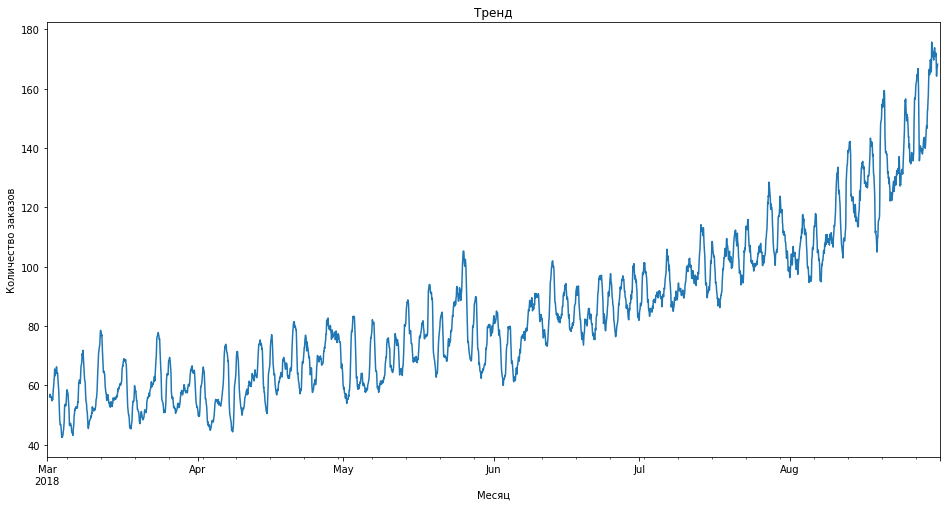

In [71]:
# Построим график тренда.
plt.figure(figsize=(16, 8))
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

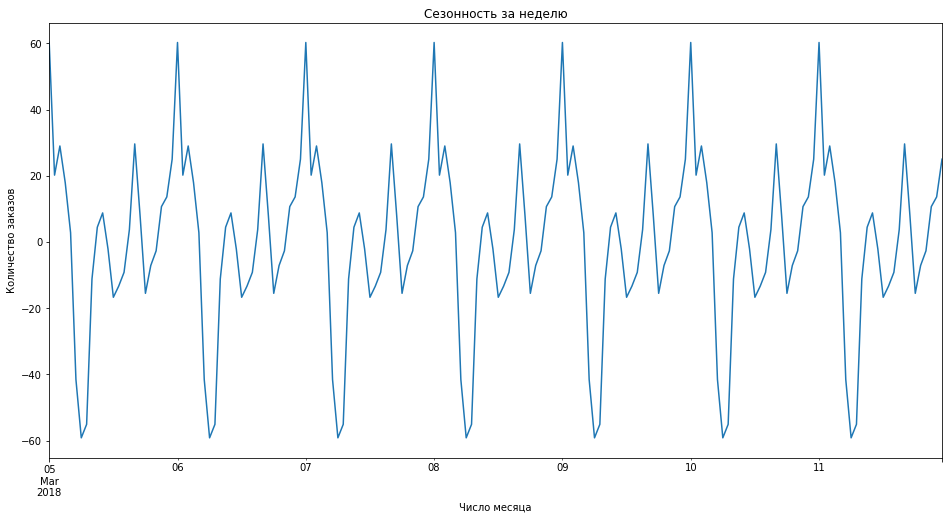

In [72]:
# Построим график сезонности за отдельно взятую неделю.
plt.figure(figsize=(16, 8))
decomposed.seasonal['2018-03-05':'2018-03-11'].plot(ax=plt.gca())
plt.title('Сезонность за неделю')  
plt.xlabel('Число месяца')
plt.ylabel('Количество заказов')
plt.show()

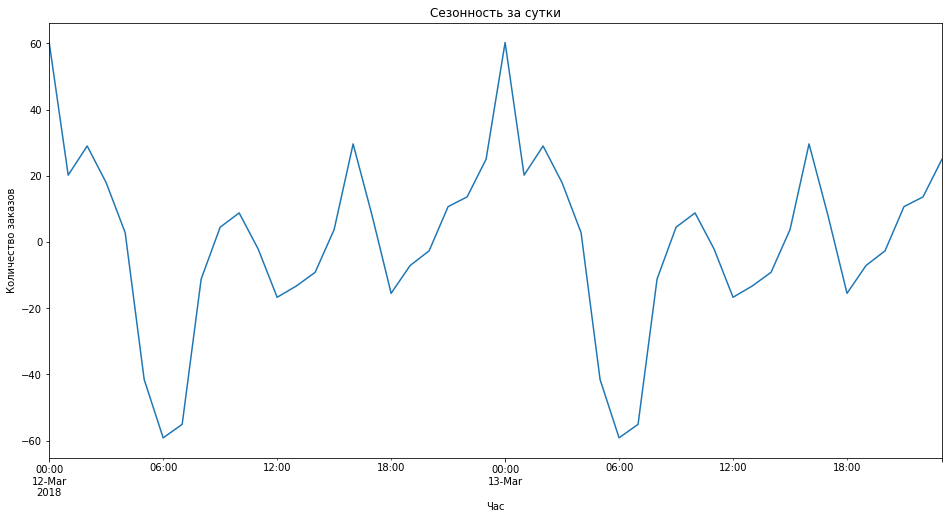

In [73]:
# Построим график сезонности за сутки.
plt.figure(figsize=(16, 8))
decomposed.seasonal['2018-03-12':'2018-03-13'].plot(ax=plt.gca())
plt.title('Сезонность за сутки')  
plt.xlabel('Час')
plt.ylabel('Количество заказов')
plt.show()

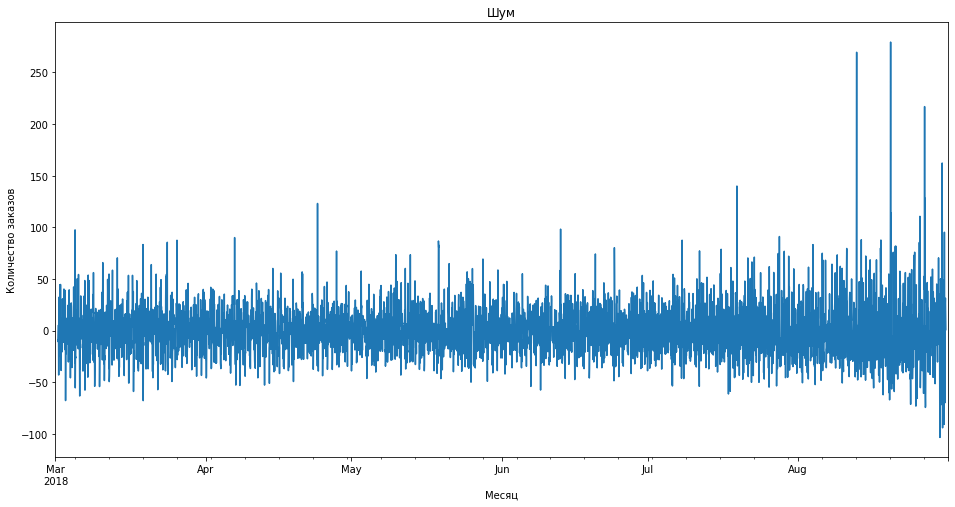

In [74]:
# Построим график остатка декомпозиции - шума.
plt.figure(figsize=(16, 8))
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Шум')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

**Промежуточный вывод:** По графику тренда видим, что количество заказов растет. По графику сезонности за неделю и за сутки видим, что число заказов не меняется от дня недели, но меняется от времени суток с пиком около полуночи и минимумом около 6 утра.

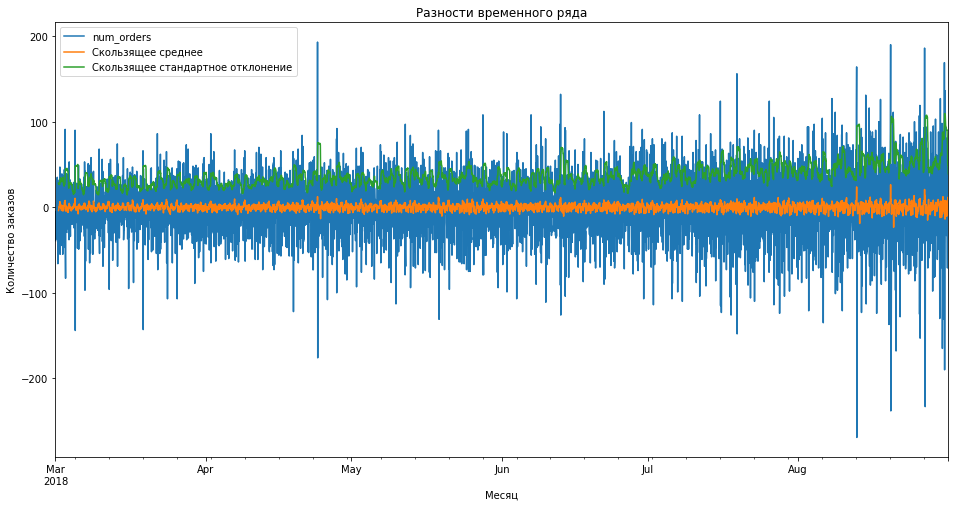

In [75]:
# Вычислим разности временного ряда, скользящее среднее и скользящее стандартное отклонение.
dfs = df - df.shift()
dfs['Скользящее среднее'] = dfs['num_orders'].rolling(15).mean()
dfs['Скользящее стандартное отклонение'] = dfs['num_orders'].rolling(15).std()

# Построим график.
dfs.plot(figsize=(16,8))
plt.title('Разности временного ряда') 
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

**Промежуточный вывод:**  По графику видим, что среднее значение и стандартное отклонение не сильно меняются, следовательно, ряд стационарен.

## Обучение моделей

### Подготовка данных к обучению

Добавим признаки к датафрейму. Стоит добавить день месяца, сдвиги и скользящее среднее. Так как данные у нас менее чем за год, месяц добавлять не будем. Из графиков видим, что день недели добавлять тоже смысла нет.

In [76]:
# Напишем функцию для добавления новых признаков.
def make_features(df, max_lag, rolling_mean_size):
    # Добавим день месяца.
    df['day'] = df.index.day
    # Добавим сдвиги.
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    # Добавим скользящее среднее.
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [77]:
make_features(df, 24, 20)
df.dropna(inplace=True)

In [78]:
RANDOM_STATE = 42
TEST_SIZE = 0.1
tscv = TimeSeriesSplit(n_splits=3)
# Разделим данные на обучающую и тестовую выборки.
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=TEST_SIZE)

### LinearRegression

In [79]:
# Инициализируем модель линейной регрессии.
model_lr = LinearRegression()

# Воспользуемся GridSearchCV для кросс-валидации модели.
param_lr = {}
grid_lr = GridSearchCV(model_lr, param_lr, scoring = 'neg_root_mean_squared_error', cv=tscv, verbose=3)
grid_lr.fit(X_train, y_train)

print('RMSE линейной регрессии:', grid_lr.best_score_*-1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ................................., score=-24.967 total time=   0.0s
[CV 2/3] END ................................., score=-26.114 total time=   0.3s
[CV 3/3] END ................................., score=-32.142 total time=   0.2s
RMSE линейной регрессии: 27.741035934997086


**Промежуточный вывод:** RMSE линейной регрессии = 27.7, что удовлетворяет заданному условию.

### DecisionTreeRegressor

In [80]:
# Инициализируем модель древа решений.
model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE)

# Зададим параметры и воспользуемся GridSearchCV для определения лучших по метрике.
param_dt = {'max_depth':range (1, 11, 2)}
grid_dt = GridSearchCV(model_dt, param_dt, scoring = 'neg_root_mean_squared_error', cv=tscv, verbose=3)
grid_dt.fit(X_train, y_train)

print('Лучшие параметры древа решений:',grid_dt.best_params_)
print('RMSE древа решений:', grid_dt.best_score_*-1)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .....................max_depth=1;, score=-30.937 total time=   0.1s
[CV 2/3] END .....................max_depth=1;, score=-33.252 total time=   0.1s
[CV 3/3] END .....................max_depth=1;, score=-45.902 total time=   0.0s
[CV 1/3] END .....................max_depth=3;, score=-28.272 total time=   0.0s
[CV 2/3] END .....................max_depth=3;, score=-29.638 total time=   0.0s
[CV 3/3] END .....................max_depth=3;, score=-41.483 total time=   0.0s
[CV 1/3] END .....................max_depth=5;, score=-28.656 total time=   0.0s
[CV 2/3] END .....................max_depth=5;, score=-30.108 total time=   0.0s
[CV 3/3] END .....................max_depth=5;, score=-37.886 total time=   0.0s
[CV 1/3] END .....................max_depth=7;, score=-29.372 total time=   0.0s
[CV 2/3] END .....................max_depth=7;, score=-33.191 total time=   0.0s
[CV 3/3] END .....................max_depth=7;, s

**Промежуточный вывод:** Лучший параметр глубины древа решений: 5, RMSE = 32.2, что удовлетворяет заданному условию.

### LightGBM

In [81]:
# Инициализируем модель LightGBM.
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

# Зададим параметры и воспользуемся GridSearchCV для определения лучших по метрике.
param_lgbm = {
    'n_estimators': [50, 100, 200],
    'num_leaves': [20, 30]}
grid_lgbm = GridSearchCV(model_lgbm, param_lgbm, scoring = 'neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=3)
grid_lgbm.fit(X_train, y_train)

print('Лучшие параметры LightGBM:', grid_lgbm.best_params_)
print('RMSE LightGBM:', grid_lgbm.best_score_*-1)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 1/3] END ..n_estimators=50, num_leaves=20;, score=-24.251 total time=  55.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 2/3] END ..n_estimators=50, num_leaves=20;, score=-25.512 total time=  59.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 3/3] END ..n_estimators=50, num_leaves=20;, score=-33.190 total time= 1.4min


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 1/3] END ..n_estimators=50, num_leaves=30;, score=-24.039 total time=  23.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 2/3] END ..n_estimators=50, num_leaves=30;, score=-24.943 total time=  19.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 3/3] END ..n_estimators=50, num_leaves=30;, score=-32.730 total time=  35.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 1/3] END .n_estimators=100, num_leaves=20;, score=-24.825 total time= 2.1min


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 2/3] END .n_estimators=100, num_leaves=20;, score=-25.622 total time=  47.9s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 3/3] END .n_estimators=100, num_leaves=20;, score=-32.672 total time= 1.1min


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 1/3] END .n_estimators=100, num_leaves=30;, score=-24.301 total time= 1.2min


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 2/3] END .n_estimators=100, num_leaves=30;, score=-25.007 total time= 1.3min


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 3/3] END .n_estimators=100, num_leaves=30;, score=-32.589 total time= 1.6min


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 1/3] END .n_estimators=200, num_leaves=20;, score=-24.931 total time= 2.0min


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 2/3] END .n_estimators=200, num_leaves=20;, score=-25.722 total time= 2.9min


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 3/3] END .n_estimators=200, num_leaves=20;, score=-32.856 total time=  15.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 1/3] END .n_estimators=200, num_leaves=30;, score=-24.452 total time=   2.6s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 2/3] END .n_estimators=200, num_leaves=30;, score=-25.049 total time=   2.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[CV 3/3] END .n_estimators=200, num_leaves=30;, score=-32.727 total time=   1.9s
Лучшие параметры LightGBM: {'n_estimators': 50, 'num_leaves': 30}
RMSE LightGBM: 27.237269659250973


**Промежуточный вывод:** Лучший параметр числа эстиматоров LightGBM: 50, число "листьев": 30. RMSE = 27.2, что удовлетворяет заданному условию.

## Тестирование моделей

Исходя из оценки метрики, остановимся на ***LightGBM***, как лучшей по RMSE. Проверим её качество и время предсказания на тестовой выборке.

In [82]:
# Протестируем наилучшую модель на тестовой выборке.
model_lgbm = LGBMRegressor(num_leaves=30, n_estimators=50, random_state=RANDOM_STATE)
model_lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
test_rmse = mean_squared_error(y_test, predictions)**0.5

print('RMSE для лучшей модели LightGBM:', test_rmse)

RMSE для лучшей модели LightGBM: 43.14623909213149


**Промежуточный вывод:** RMSE LightGBM на тестовой выборке = 43.1, что удовлетворяет заданному условию.

## Общий вывод

**Цель исследования:** Построили модели машинного обучения для прогнозирования количества заказов такси на следующий час. Оценили их по критериям, указанным заказчиком.

**Подготовка данных:** Проверили данные на пропуски и монотонность, ресемплировали их по одному часу.

**Анализ данных:** Декомпозировали датафрейм, построили графики тренда, сезонности за неделю и сутки, остатков декуомпозиции. По графику тренда увидели, что количество заказов растет. По графику сезонности за неделю и за сутки увидели, что число заказов не меняется от дня недели, но меняется от времени суток с пиком около полуночи и минимумом около 6 утра. Построили график разностей временного ряда. По нему увидели, что среднее значение и стандартное отклонение не сильно меняются, следовательно, ряд стационарен.

**Обучение моделей:** Добавили признаки к датафрейму: день месяца, сдвиги и скользящее среднее. Так как данные у нас менее чем за год, месяц и день недели добавлять не стали. Обучили 3 модели машинного обучения, подобрав гиперпараметры, оценили модели по метрике RMSE, которая по указаниям заказчика должна быть меньше 48:
- LinearRegression: RMSE = 27.7, что удовлетворяет заданному условию.
- DecisionTreeRegressor: Лучший параметр глубины: 5, RMSE = 32.2, что удовлетворяет заданному условию.
- LightGBM: Лучший параметр числа эстиматоров: 50, число "листьев": 30. RMSE = 27.2, что удовлетворяет заданному условию.

**Тестирование моделей:** Исходя из оценки метрики, остановились на LightGBM, как лучшей по RMSE. RMSE LightGBM на тестовой выборке = 43.1, что удовлетворяет заданному условию.